# Challenge 2

In [87]:
import pandas as pd 
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
import pickle as pkl

## Load the data

In [85]:
data = pd.read_csv('./Data/Cell_a.csv')
# Actual time needed to compute the task
data['X'] = data.CPU.apply(lambda x: x/0.1)
# Time in seconds
data['Arrival_Time'] = data.Arrival_Time.apply(lambda x: x/1_000_000) 
display(data)

,Job_ID,Task_ID,Arrival_Time,CPU,Memory,X
0,375000667413,0,6.030263e+02,0.041851,0.001169,0.418510
1,375000669289,0,6.064130e+02,0.024968,0.001179,0.249681
2,375000670586,0,6.089945e+02,0.024176,0.001173,0.241756
3,375000670588,0,6.089945e+02,0.019552,0.001163,0.195522
4,375000670590,0,6.090429e+02,0.028044,0.001179,0.280437
...,...,...,...,...,...,...
2329128,400465219425,0,2.678944e+06,0.000343,0.000004,0.003433
2329129,400465219425,1,2.678944e+06,0.000557,0.000004,0.005569
2329130,400465256347,0,2.678955e+06,0.002459,0.000050,0.024586
2329131,400465256349,0,2.678955e+06,0.004349,0.000052,0.043488


## The data

C:\Users\user\AppData\Local\Temp\ipykernel_8828\2635261578.py:11: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(ecdf_X.x), ecdf_X.y, color = 'green')
C:\Users\user\AppData\Local\Temp\ipykernel_8828\2635261578.py:11: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(ecdf_X.x), ecdf_X.y, color = 'green')


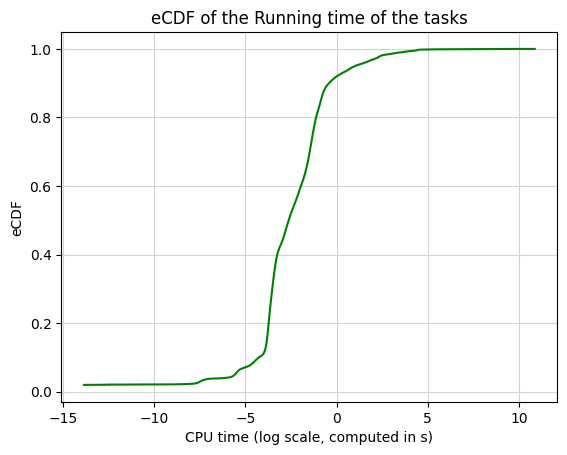

In [114]:
ecdf_X = ECDF(data.CPU)
'''ecdf_X = ECDF(data.CPU)

fig, ax = plt.subplots()
ax.set_yticks([0.2, 0.6, 0.8], minor=False)
ax.set_yticks([0.3, 0.55, 0.7], minor=True)
ax.yaxis.grid(True, which='major')
ax.yaxis.grid(True, which='minor')
'''
plt.plot(np.log(ecdf_X.x), ecdf_X.y, color = 'green')
plt.xlabel('CPU time (log scale, computed in s)')
plt.ylabel('eCDF')
plt.title('eCDF of the Running time of the tasks')
plt.grid(which='major', color = 'lightgray')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_8828\1843209325.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(ecdf_Jobs.x), ecdf_Jobs.y, color = 'green')


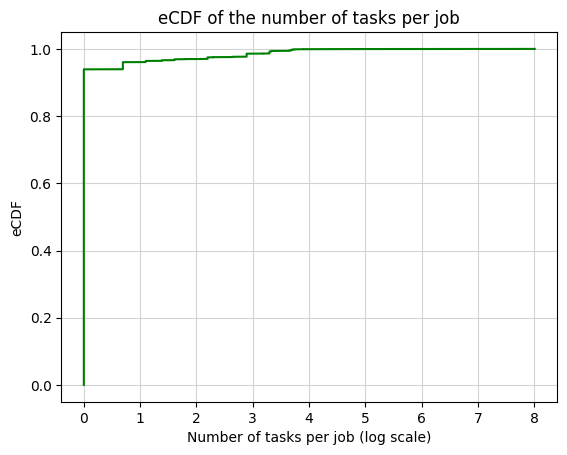

In [118]:
ecdf_Jobs = ECDF(data.groupby('Job_ID').size())
plt.plot(np.log(ecdf_Jobs.x), ecdf_Jobs.y, color = 'green')
plt.xlabel('Number of tasks per job (log scale)')
plt.ylabel('eCDF')
plt.title('eCDF of the number of tasks per job')
plt.grid(which='major', color = 'lightgray')
plt.show()

In [80]:
np.sum(data.groupby('Job_ID').size() == 1)/len(data.groupby('Job_ID').size())

0.9478316581977894

C:\Users\user\AppData\Local\Temp\ipykernel_8828\3519011143.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(ecdf_Memory.x), ecdf_Memory.y, color = 'green')
C:\Users\user\AppData\Local\Temp\ipykernel_8828\3519011143.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(ecdf_Memory.x), ecdf_Memory.y, color = 'green')


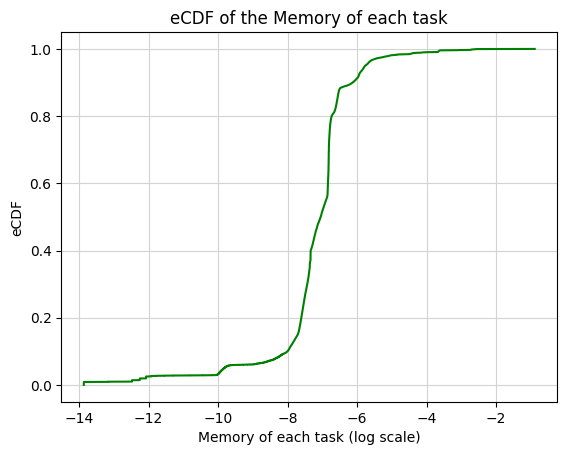

In [119]:
ecdf_Memory = ECDF(data.Memory)
plt.plot(np.log(ecdf_Memory.x), ecdf_Memory.y, color = 'green')
plt.xlabel('Memory of each task (log scale)')
plt.ylabel('eCDF')
plt.title('eCDF of the Memory of each task')
plt.grid(which='major', color = 'lightgray')
plt.show()

In [ ]:
# TODO scrivi

In [86]:
(max(data.Arrival_Time) - min(data.Arrival_Time)) /(60*60*24)

30.999604561354165

## Equilibrio

In [88]:
intervals = np.linspace(min(data.Arrival_Time), max(data.Arrival_Time), num = 501, dtype='int64')
times = list(data['Arrival_Time'])
lambdas = []
idx = 0
for i, interv in enumerate(intervals[1:]):
    tasks = [x for x in times[idx:] if intervals[i]<=x and x< interv]
    idx = times.index(tasks[-1])
    lambdas.append(len(tasks)/(interv-intervals[i]))

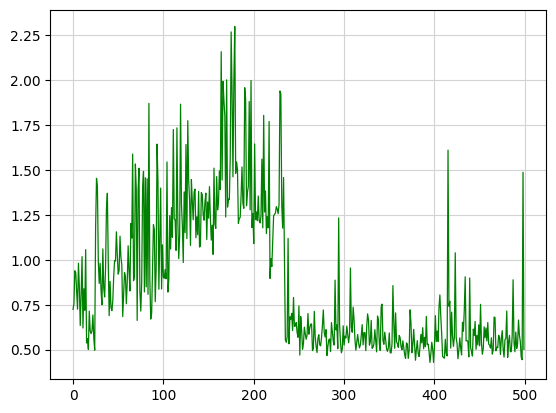

In [134]:
plt.plot(lambdas, color = 'green', linewidth = 0.9)
plt.grid(which='major', color = 'lightgray')
plt.show()

In [90]:
np.mean(lambdas)

0.8696114821463697

## Functions

In [ ]:
# Shortest Remaining Processing Time (SRPT)
def Scheduling(new_time, prev_time, servers):
    # How much time has passed
    time = new_time - prev_time
    # To store the possible completed tasks 
    completed = []
    # Iterating over the servers
    for i, server in servers.items():
        # To count the passing time
        spent_in_server = 0

        if(server['current_task'] == None and len(server['queue']) == 0):
            continue

        if(server['current_task'] != None):
            # Extract the current task
            task = server['current_task']
            server['current_task'] = None

            # If the current task has finished and was not just placed in the queue 
            while((task['X'] - time + spent_in_server) <= 0 and task['Arrival_Time']<=prev_time):
                # Store it in the completed list with it's finishing time
                completed.append((task, prev_time + task['X'] + spent_in_server - task['Arrival_Time'], i))
                #server['Memory'] += task['Memory']
                # Take out from the time the one that was used to finish the task
                spent_in_server += task['X'] 
                task = None

                if(len(server['queue']) != 0):
                    # Select the next task that the server have started
                    task = sorted([x for x in server['queue']], key = lambda x: x['X'])[0]
                    # And remove it from the queue
                    server['queue'].remove(task)
                    
                else:
                    break
            # If there is still a task
            if(task):
                # and it's not one that was just placed in the queue
                if(task['Arrival_Time']<prev_time):
                    # Update the remaining time
                    task['X'] -= (time - spent_in_server)
                    spent_in_server = time
                # Move the current task to the server queue
                server['queue'].append(task) 
            
            # Update the unfinished work
            server['Unfinished_work'] -=  spent_in_server

        if(len(server['queue']) != 0):
            # Select the new current task as the one with less remaining time
            server['current_task'] = sorted([x for x in server['queue']], key = lambda x: x['X'])[0]
            # And remove from the queue the new current task
            server['queue'].remove(server['current_task'])

        else:
            server['Unfinished_work'] = 0
        
    return completed

In [39]:
# Shortest Remaining Processing Time (SRPT)
def Scheduling(new_time, prev_time, servers, data):
    # How much time has passed
    time = new_time - prev_time
    # To store the possible completed tasks
    completed = []
    # Iterating over the servers
    for i, server in servers.items():
        if(server['current_task'] == None and len(server['queue']) == 0):
            continue

        if(server['current_task'] != None):
            # Extract the current task
            task = server['current_task']
            server['current_task'] = None

            # If the current task has finished 
            if(data.at[task, 'X']-time <= 0):
                # store it in the completed list with it's finishing time
                completed.append((task, data.at[task, 'Job_ID'], prev_time + data.at[task, 'X'] - data.at[task, 'Arrival_Time'], i))
                server['Memory'] += data.at[task, 'Memory']
            # Else
            else:
                # Update the remaining time
                remaining_time = data.at[task, 'X'] - time
                data.at[task,'X'] = remaining_time
                # And move the current task to the server queue
                server['queue'].append(task) 

        if(len(server['queue']) != 0):
            # Select the new current task as the one with less remaining time
            server['current_task'] = data.loc[server['queue'],'X'].sort_values().index[0]
            # And remove from the queue the new current task
            server['queue'].remove(server['current_task'])
        
    return completed

In [40]:
def Update_UW(time, servers, data, task, selected_server):
    for i, server in servers.items():
        if(server['current_task'] != None):
            server['Unfinished_work'] = max([0, server['Unfinished_work'] - min([time, data.at[server['current_task'], 'X']])])

    if (selected_server != 0):
        servers[selected_server]['Unfinished_work'] += data.at[task, 'X']

In [41]:
# JBT
def Dispatching(servers, task, data, time):
    # Unfinished_work
    lower = min([server['Unfinished_work'] for server in servers.values()])
    possible_servers = [i for i, v in servers.items() if v['Unfinished_work'] <= (1+0.25)*lower]
    possible_servers = [(i, v['Memory']) for i, v in servers.items() if i in possible_servers and (v['Memory'] - data.at[task, 'Memory'])>=0]
    selected_server = sorted(possible_servers, reverse=True, key = lambda x: x[1])[0][0]

    # Add new task to server
    servers[selected_server]['queue'].append(task)
    servers[selected_server]['Memory'] -= data.at[task, 'Memory']

    # Updata the unfinished work
    Update_UW(time, servers, data, task, selected_server) 

    return(selected_server)

In [79]:
data = pd.read_csv('./Data/Cell_a.csv')
# Take CPU time in milliseconds
data['CPU'] = data.CPU.apply(lambda x: x*1000)
# Actual time needed to compute the task
data['X'] = data.CPU.apply(lambda x: x/0.1)
test_data = data.iloc[list(range(10000))]
servers = dict([(i+1, {'queue':[], 'Memory': 1, 'current_task': None, 'Unfinished_work': 0}) for i in range(64)])

In [80]:
results = []
used_data = []

current_data = pd.DataFrame(columns=data.columns)
prev_time = test_data.iloc[0].Arrival_Time
for job in tqdm(range(len(test_data))):
    current_data.loc[job] = data.iloc[job]
    new_time = current_data.at[job,'Arrival_Time']
    # Assegna a server secondo Unfinished_work
    selected_server = Dispatching(servers, job, current_data, new_time - prev_time)
    
    # Fai update
    completed = Scheduling(new_time, prev_time, servers, current_data)
    if(len(completed)):
        results = results + completed

    current_data.drop([c[0] for c in completed], inplace=True)
    used_data.append(len(current_data))
    prev_time = new_time

100%|██████████| 10000/10000 [00:58<00:00, 171.54it/s]


In [81]:

final_time = 0

for i, server in servers.items():
    last_time = current_data.at[len(test_data)-1,'Arrival_Time']
    while(server['current_task']!=None):
        last_time += data.iloc[server['current_task'], 5]
        time_in_server = last_time - data.iloc[server['current_task'], 2]
        results.append((server['current_task'], data.iloc[server['current_task'], 0], time_in_server, i))
        server['current_task']=None

        if(len(server['queue']) != 0):
            # Select the new current task as the one with less remaining time
            server['current_task'] = data.loc[server['queue'],'X'].sort_values().index[0]
            # And remove from the queue the new current task
            server['queue'].remove(server['current_task'])


## Testo cose

In [91]:
def server_iteration(server, prev_time, time):
    # To store the information of the tasks that ended during the time interval
    completed = []

    # To count the passing time
    time_in_server = 0
    
    # Extract the server informations
    server_id = server[0]
    server_content = server[1]

    # In this case the server was not computing any task
    if(server_content['current_task'] == None and len(server_content['queue']) == 0):
        return completed
    

    if(server_content['current_task'] != None):
        # Extract the task that the server was computing
        task = server_content['current_task']
        server_content['current_task'] = None

        # while there are tasks that finished during the time interval
        while(task['X'] - time + time_in_server <= 0 and task['Arrival_Time'] <= prev_time):

            # Store the informations of the completed task: (task, time to complete it, server that did the task)
            completed.append((task, prev_time + task['X'] + time_in_server - task['Arrival_Time'], server_id))
            
            # sum to the time spent in server during the iteration the time used to finish the task
            time_in_server += task['X']
            task = None

            # If there is some task in the queue
            if(len(server_content['queue'])):
                # Select the server that was initiated after 
                task = min([x for x in server_content['queue']], key = lambda x: x['X'])
                # And remove it from the queue
                server_content['queue'].remove(task)
            else:
                break
    # The server wasn't working on anything, but it has something in queue
    else:
        # Select the server that was initiated after 
        task = min([x for x in server_content['queue']], key = lambda x: x['X'])
        # And remove it from the queue
        server_content['queue'].remove(task)
    
    # If there is a task in the server that was started (but didn't end) or has been put in queue during the time interval
    if(task):
        # And the task hasn't just arrived
        if(task['Arrival_Time'] <= prev_time):
        # Take out the amount of work done 
            task['X'] -= (time - time_in_server)
        
        # Set the task as current task
        server_content['current_task'] = task
        # Take out of the Unfinished work the amount of work done
        server_content['Unfinished_work'] -= time_in_server
    
    else:
        server_content['Unfinished_work'] = 0

    # Return the informations about the completed tasks
    return completed


# Function to check if any of the servers passed the threshold
def Update_dispatcher_list(servers, dispatcher_list):

    # to count the msgs that will be sent from the servers to the dispatcher
    L_update = 0 

    # For each of the servers
    for i, server in servers.items():
        # If the server goes from busy to idle
        if(server['Unfinished_work'] <= server['Threshold'] and dispatcher_list[i-1] == 0):
            # Send the msg and change the list to 1
            L_update +=1 
            dispatcher_list[i-1] = 1

        # If the server goes from idle to busy
        if(server['Unfinished_work'] > server['Threshold'] and dispatcher_list[i-1] == 1):
            # Send the msg and change the list to 0
            L_update +=1 
            dispatcher_list[i-1] = 0
    
    # Give back how many msg were sent and the new server status
    return L_update, dispatcher_list


In [92]:
# Shortest Remaining Processing Time (SRPT)
def Scheduling(new_time, prev_time, servers, dispatcher_list):
    # How much time has passed
    time = new_time - prev_time
    # To store the possible completed tasks 
    completed = []
    # Iterating over the servers
    for server in servers.items():
        # Compute the server iteration
        completed_in_server = server_iteration(server, prev_time, time)
        # Store the tasks completed during the server iteration
        completed = completed + completed_in_server
        
    # Check if any of the servers passed the threshold
    L, dispatcher_list = Update_dispatcher_list(servers, dispatcher_list)

    # Return the infromation of the finished tasks, the number of msg sent and the servers status
    return completed, L, dispatcher_list

In [138]:
def Dispatching(servers, task, dispatcher_list, time, check, task_assigned):
    # To store the number of msg exchanged
    L_dispatching = 0 

    # If we have to recompute the threshold (timeout or all servers busy)
    if(check or np.sum(dispatcher_list) == 0):

        # If there is heavy traffic, so if (number of task assigned)/(len of the time interval) over 1 or if all the server are 'busy'
        if(task_assigned['count']/(intervals[task_assigned['interval_idx']]-intervals[task_assigned['interval_idx']-1]) > 1 or np.sum(dispatcher_list) == 0):
            # We take a less conservative threshold
            threshold = np.quantile(q = 0.5, a = [server['Unfinished_work'] for server in servers.values()])
        # If the threshold is recomputed just for the time out
        else:
            # We take a more conservative threshold
            threshold = np.quantile(q = 0.25, a = [server['Unfinished_work'] for server in servers.values()])
        
        # Index of the 'new' idle servers
        idx = [i - 1  for i, server in servers.items() if server['Unfinished_work'] <= threshold]
        
        # new dispatcher list
        dispatcher_list = np.zeros(64) 
        dispatcher_list[idx] = 1
        
        # Set the new threshold
        for server in servers.values():
            server['Threshold'] = threshold
        
        # When we have to compute the threshold we will need to send 64 msg to know the Unfinished_works
        L_dispatching += 64*2

    # Select the idle servers
    possible_servers = np.where(dispatcher_list == 1)[0] + 1
    # And choose one randomly
    selected_server = np.random.choice(possible_servers)

    # Add new task to server
    servers[selected_server]['queue'].append(task)
    servers[selected_server]['Unfinished_work'] += task['X']

    return  dispatcher_list, L_dispatching

In [137]:
def empty_servers(servers):    
    # To store the time the last server finishes 
    final_time = 0
    # To store the last results
    completed = []

    # For each of the servers
    for i, server in servers.items():
        last_time = data.at[len(test_data)-1,'Arrival_Time']
        # If there are still tasks to do
        while(server['current_task']!=None):
            # Save how much time it needs to be ended
            last_time += server['current_task']['X']

            # Compute how much time it was in the server
            time_in_server = last_time - server['current_task']['Arrival_Time']

            # Append the result
            completed.append((server['current_task'], time_in_server, i))
            server['current_task']=None

            # If there is still something in queue
            if(len(server['queue']) != 0):
                # Select the new current task as the one with less remaining time
                server['current_task'] = min([x for x in server['queue']], key = lambda x: x['X'])
                # And remove from the queue the new current task
                server['queue'].remove(server['current_task'])
        
        # Get the maximum of times the servers finish
        final_time = max([last_time, final_time])

    # Ruturn the time and the last results
    return final_time, completed

In [155]:
def compute_evaluations(results, data, base = False):
    # Find all the jobs_id
    Jobs = list(data.Job_ID)
    # And their arrival times
    Starting_times = list(data.Arrival_Time)

    # Create the dictionary with entries for each (unique) job
    RT = {}
    for J, S in zip(Jobs, Starting_times):
        if J not in RT.keys():
            RT[J] = {'Start': S, 'End': 0}
            
    for result in results:
        task = result[0]
        final_time = result[1] + task['Arrival_Time'] 
        RT[task['Job_ID']]['End'] = max([RT[task['Job_ID']]['End'], final_time])
        RT[task['Job_ID']]['RT'] = RT[task['Job_ID']]['End']- RT[task['Job_ID']]['Start']

        if('Service_time' not in RT[task['Job_ID']].keys()):
            RT[task['Job_ID']]['Service_time'] = task['X']
        else:
            RT[task['Job_ID']]['Service_time'] += task['X']

        if(RT[task['Job_ID']]['Service_time'] == 0):
            RT[task['Job_ID']]['Slow_down'] = 1
            continue
        RT[task['Job_ID']]['Slow_down'] = RT[task['Job_ID']]['RT']/RT[task['Job_ID']]['Service_time']

    Q = pd.DataFrame(RT)
    Q = Q.T

    return Q
                
            

In [141]:
data = pd.read_csv('./Data/Cell_a.csv')
# Arrival time from microseconds to seconds
data['Arrival_Time'] = data.Arrival_Time.apply(lambda x: x/1_000_000) 

# Actual time needed to compute the task
data['X'] = data.CPU.apply(lambda x: x/0.1)
test_data = data.iloc[list(range(100000))]
servers = dict([(i+1, {'queue':[], 'Threshold': 0, 'current_task': None, 'Unfinished_work': 0}) for i in range(64)])
dispatcher_list = np.ones(64)
intervals = np.linspace(603.0263, 2678968.860401, num = 501)

In [142]:
results = []
L = []
interval = {'interval_idx': 1, 'count': 0}
check = 0 
prev_time = data.iloc[0].Arrival_Time
for job in tqdm(range(len(data))):
    #current_data.loc[job] = data.iloc[job]
    new_task = dict(data.iloc[job])
    new_task['index'] = job
    new_time = new_task['Arrival_Time']

    if(new_time <= intervals[interval['interval_idx']]):
        interval['count'] += 1
    else:
        interval = {'interval_idx': interval['interval_idx']+1, 'count': 0}
        check = 1
        
    # Assegna a server secondo Unfinished_work
    dispatcher_list, L_aux = Dispatching(servers, new_task, dispatcher_list, new_time - prev_time, check, interval)
    check = 0
    L.append(L_aux)
    # Fai update
    completed, L_aux , dispatcher_list = Scheduling(new_time, prev_time, servers, dispatcher_list)

    if(len(completed)):
        results = results + completed
        
    prev_time = new_time

final_time, completed = empty_servers(servers)
results = results + completed

100%|██████████| 2329133/2329133 [2:42:01<00:00, 239.57it/s]  


In [143]:
with open('results.pkl', 'wb') as f:
    pkl.dump(results, f)

In [144]:
with open('final_time.pkl', 'wb') as f:
    pkl.dump(final_time, f)

In [145]:
np.mean(L)

0.21746117546743787

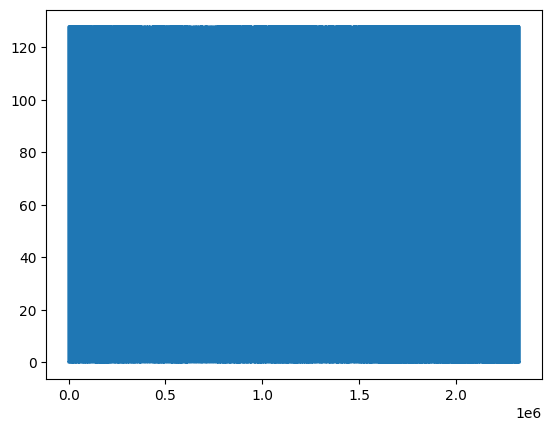

In [146]:
plt.plot(L)
plt.show()

In [156]:
Q = compute_evaluations(results, data)

In [149]:
Jobs = list(data.Job_ID)
Starting_times = list(data.Arrival_Time)
RT = {}
for J, S in zip(Jobs, Starting_times):
    if J not in RT.keys():
        RT[J] = {'Start': S, 'End': 0}

In [150]:
for result in results:
    task = result[0]
    final_time = result[1] + task['Arrival_Time'] 
    RT[task['Job_ID']]['End'] = max([RT[task['Job_ID']]['End'], final_time])

r_times = []
for j, rt in RT.items():
    r_times.append(rt['End']-rt['Start'])
    RT[j]['RT'] = rt['End']-rt['Start']

In [151]:
np.mean(r_times)

2877.4724792772886

In [152]:
for result in results:
    task = result[0]
    if('Service_time' not in RT[task['Job_ID']].keys()):
        RT[task['Job_ID']]['Service_time'] = result[0]['X']
    else:
        RT[task['Job_ID']]['Service_time'] += result[0]['X']

In [153]:
Slow_down = []
for j , rt in RT.items():
    if(rt['Service_time'] == 0):
        RT[j]['Slow_down'] = 1
        continue
    RT[j]['Slow_down'] = rt['RT']/rt['Service_time']

In [135]:
Q = pd.DataFrame(RT)
Q = Q.T

In [157]:
np.mean(list(Q.RT))

2877.4724792772886

In [158]:
np.mean(list(Q.Slow_down))

173874.41736605403

C:\Users\user\AppData\Local\Temp\ipykernel_8828\2387708048.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(ecdf_RT.x),  1- ecdf_RT.y, color = 'green')
C:\Users\user\AppData\Local\Temp\ipykernel_8828\2387708048.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(ecdf_RT.x),  1- ecdf_RT.y, color = 'green')


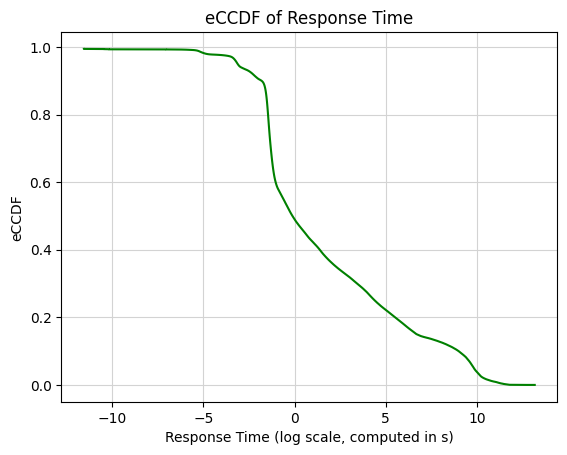

In [160]:
ecdf_RT = ECDF(Q.RT)
plt.plot(np.log(ecdf_RT.x),  1- ecdf_RT.y, color = 'green')
plt.xlabel('Response Time (log scale, computed in s)')
plt.ylabel('eCCDF')
plt.title('eCCDF of Response Time')
plt.grid(which='major', color = 'lightgray')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_8828\3562597387.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(ecdf_Service_time.x),  1- ecdf_Service_time.y, color = 'green')


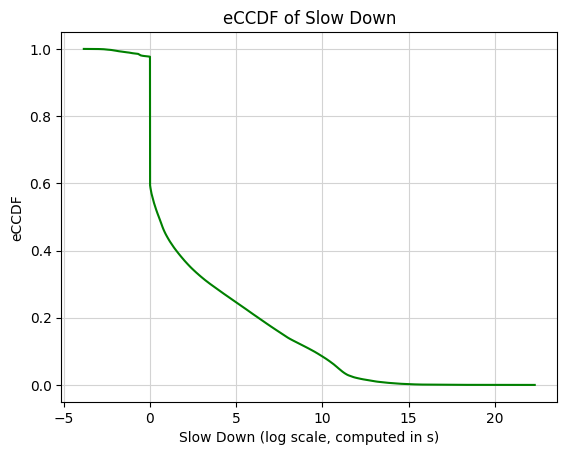

In [159]:
ecdf_Service_time = ECDF(Q.Slow_down)
plt.plot(np.log(ecdf_Service_time.x),  1- ecdf_Service_time.y, color = 'green')
plt.xlabel('Slow Down (log scale, computed in s)')
plt.ylabel( 'eCCDF')
plt.title('eCCDF of Slow Down')
plt.grid(which='major', color = 'lightgray')
plt.show()

In [139]:
# rho
data['CPU'] = data.CPU.apply(lambda x: x*1000)
# Actual time needed to compute the task
data['X'] = data.CPU.apply(lambda x: x/0.1)

rho = np.zeros(64)
#time_passed = test_data.iat[-1,2]-test_data.iat[0,2]
for result in results:
    rho[result[-1] - 1] += test_data.iloc[result[0]['index']]['X']

rho = rho/(final_time - test_data.iat[0,2])
rho

array([0.43382292, 0.43005123, 0.38156795, 0.86566545, 0.42186285,
       0.96529649, 0.63894146, 0.33529249, 0.41600519, 0.32535137,
       0.45663976, 0.57226163, 0.32741926, 0.26525587, 0.34305186,
       0.34374986, 0.33855643, 0.33639876, 0.57936366, 0.35833761,
       0.34024478, 0.26247877, 0.36528536, 0.56033399, 0.5436326 ,
       0.27186523, 0.34187823, 0.33811395, 0.44353866, 0.35743813,
       0.88971482, 0.45920648, 0.57771759, 0.64441237, 0.29456797,
       0.58066762, 0.33659352, 0.45332715, 0.44462766, 0.42220643,
       0.38995989, 0.62567091, 0.35481341, 0.36560677, 0.91398106,
       0.40036962, 0.92334989, 0.41856175, 0.47368484, 0.35124196,
       0.38817904, 0.43733199, 0.4053083 , 0.45792687, 0.41304703,
       0.93303424, 0.38114055, 0.34034515, 0.32561304, 0.36923166,
       0.58956099, 0.36857853, 0.93621656, 0.64636161])

## Baseline
 
Least work left + First come first served

In [5]:
# Function to compute the results for our baseline dispatching + scheduling algorithm
def Baseline(servers, task, time):

    # Take out the time passed from each server
    for server in servers.keys():
        servers[server] = max([0, servers[server] - time])

    # Select the server with less work left to do
    selected_server = min([server for  server in servers.items()], key = lambda x: x[1])[0]
    # Add the time needed to compute the task just assigned
    servers[selected_server] += task['X']

    # Return the result of the task
    return (task,  servers[selected_server], selected_server)


In [53]:
data = pd.read_csv('./Data/Cell_a.csv')
# Arrival time from microseconds to seconds
data['Arrival_Time'] = data.Arrival_Time.apply(lambda x: x/1_000_000)
# Actual time needed to compute the task
data['X'] = data.CPU.apply(lambda x: x/0.1)
# Get only the data that has CPU different from 0
data = data[data.CPU != 0]
servers = dict([(i+1, 0) for i in range(64)])

In [7]:
results_base = []
L = []
prev_time = data.iloc[0].Arrival_Time
final_time = 0

for job in tqdm(range(len(data))):

    new_task = dict(data.iloc[job])
    new_task['index'] = job
    new_time = new_task['Arrival_Time']

    result = Baseline(servers, new_task, new_time - prev_time)
    results_base.append(result)
    
    prev_time = new_time
    final_time = max([final_time, result[1] + new_time])


100%|██████████| 2282872/2282872 [03:22<00:00, 11288.26it/s]


In [44]:
Jobs = list(data.Job_ID)
Starting_times = list(data.Arrival_Time)
RT = {}
for J, S in zip(Jobs, Starting_times):
    if J not in RT.keys():
        RT[J] = {'Start': S, 'End': 0}

In [45]:
for result in results_base:
    task = result[0]
    final_time = result[1] + task['Arrival_Time'] 
    RT[task['Job_ID']]['End'] = max([RT[task['Job_ID']]['End'], final_time])

for j, rt in RT.items():
    RT[j]['RT'] = rt['End']-rt['Start']

In [46]:
for result in results_base:
    task = result[0]
    if('Service_time' not in RT[task['Job_ID']].keys()):
        RT[task['Job_ID']]['Service_time'] = result[0]['X']
    else:
        RT[task['Job_ID']]['Service_time'] += result[0]['X']

In [47]:
Slow_down = []
for j , rt in RT.items():
    RT[j]['Slow_down'] = rt['RT']/rt['Service_time']

In [48]:
Q = pd.DataFrame(RT)
Q = Q.T

In [49]:
np.mean(list(Q.RT))

27603.90113509617

In [50]:
np.mean(list(Q.Slow_down))

1241675.5748628979

C:\Users\user\AppData\Local\Temp\ipykernel_8828\2387708048.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(ecdf_RT.x),  1- ecdf_RT.y, color = 'green')


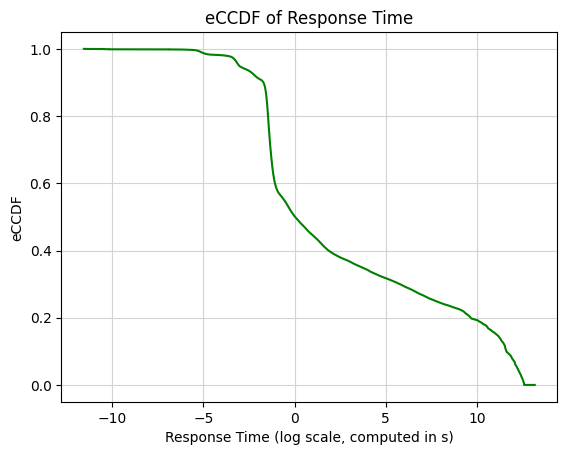

In [136]:
ecdf_RT = ECDF(Q.RT)
plt.plot(np.log(ecdf_RT.x),  1- ecdf_RT.y, color = 'green')
plt.xlabel('Response Time (log scale, computed in s)')
plt.ylabel('eCCDF')
plt.title('eCCDF of Response Time')
plt.grid(which='major', color = 'lightgray')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_8828\3562597387.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(ecdf_Service_time.x),  1- ecdf_Service_time.y, color = 'green')


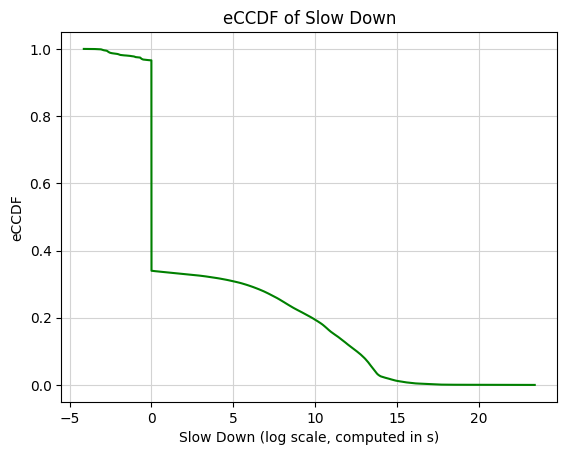

In [135]:
ecdf_Service_time = ECDF(Q.Slow_down)
plt.plot(np.log(ecdf_Service_time.x),  1- ecdf_Service_time.y, color = 'green')
plt.xlabel('Slow Down (log scale, computed in s)')
plt.ylabel( 'eCCDF')
plt.title('eCCDF of Slow Down')
plt.grid(which='major', color = 'lightgray')
plt.show()

In [54]:
# rho
rho = np.zeros(64)
start = data.iat[0,2]
for result in results_base:
    rho[result[-1] - 1] += data.iat[result[0]['index']]['X']

rho = rho/(final_time - start)
round(rho, 3)

array([0.89504235, 0.81614545, 0.81033834, 0.7940678 , 0.77201241,
       0.73956485, 0.77588906, 0.75809065, 0.75917208, 0.73097916,
       0.71487684, 0.69935774, 0.63960553, 0.6145583 , 0.6303986 ,
       0.63596444, 0.595817  , 0.57934471, 0.5660167 , 0.56512262,
       0.57977048, 0.57343717, 0.58133617, 0.53999068, 0.53303037,
       0.55248791, 0.52256386, 0.50556569, 0.51626753, 0.49767349,
       0.48035816, 0.45998862, 0.50199447, 0.48121944, 0.47323679,
       0.46317807, 0.45150068, 0.48071102, 0.45028569, 0.43550321,
       0.43128951, 0.43614568, 0.4172013 , 0.43600709, 0.43158954,
       0.4660407 , 0.48666994, 0.44168486, 0.4051231 , 0.41044233,
       0.41999546, 0.41785356, 0.3897005 , 0.4528    , 0.41251704,
       0.43445018, 0.45028127, 0.4611049 , 0.41800288, 0.45877875,
       0.40914851, 0.40812906, 0.39207445, 0.39968937])

In [96]:
np.round(rho, 3)

array([0.895, 0.816, 0.81 , 0.794, 0.772, 0.74 , 0.776, 0.758, 0.759,
       0.731, 0.715, 0.699, 0.64 , 0.615, 0.63 , 0.636, 0.596, 0.579,
       0.566, 0.565, 0.58 , 0.573, 0.581, 0.54 , 0.533, 0.552, 0.523,
       0.506, 0.516, 0.498, 0.48 , 0.46 , 0.502, 0.481, 0.473, 0.463,
       0.452, 0.481, 0.45 , 0.436, 0.431, 0.436, 0.417, 0.436, 0.432,
       0.466, 0.487, 0.442, 0.405, 0.41 , 0.42 , 0.418, 0.39 , 0.453,
       0.413, 0.434, 0.45 , 0.461, 0.418, 0.459, 0.409, 0.408, 0.392,
       0.4  ])

In [55]:
np.mean(rho)

0.5384247518308163